# 0. Установка зависимостей

Импортируем некоторые базовые библиотеки. Остальные будут подгружаться дальше по коду

In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import random
import torch
from IPython.display import clear_output
import seaborn as sns
import multiprocessing
import zipfile
import sys

import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

import warnings
warnings.filterwarnings('ignore')

Посмотрим сколько ядер cpu доступно.

In [ ]:
CORES = multiprocessing.cpu_count()
CORES

2

Подгрузим гугл диск.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Загрузим датасет прямо с kaggle.
Файл kaggle.json можно получить следующим образом:

 `kaggle profile -> account -> скроллим до API секции -> Expire API Token -> Create New API Token`


In [ ]:
import os
# Путь до папки с файлом kaggle.json
os.environ['KAGGLE_CONFIG_DIR'] = '/content/drive/MyDrive/kaggle'
!pip install kaggle
!kaggle datasets download -d blackmoon/russian-language-toxic-comments
!unzip russian-language-toxic-comments.zip
!rm russian-language-toxic-comments.zip

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  0% 0.00/1.49M [00:00<?, ?B/s]
100% 1.49M/1.49M [00:00<00:00, 108MB/s]
Archive:  russian-language-toxic-comments.zip
  inflating: labeled.csv             


Установим вспомогательные библиотеки.

In [ ]:
!pip install transformers sentencepiece
!pip install gensim
!pip install wget

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.7 MB 3.9 MB/s 
     |████████████████████████████████| 1.2 MB 47.8 MB/s 
     |████████████████████████████████| 6.6 MB 22.8 MB/s 
     |████████████████████████████████| 596 kB 60.3 MB/s 
     |████████████████████████████████| 101 kB 11.7 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9675 sha256=ac9d8097349441dc842fe279100911f292c4b0bd2842bfaa29fe0dca685e905e
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully bu

Установим библиотеку pymorphy2, которую будем впоследствии использовать для лемматизации.

In [ ]:
!pip install pymorphy2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 55 kB 2.0 MB/s 
     |████████████████████████████████| 8.2 MB 6.9 MB/s 


Определим константы

In [ ]:
RANDOM_STATE = 42
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

# 1. Предобработка

## Загрузка данных

Посмотрим на случайную выборку наших данных

In [ ]:
data = pd.read_csv('labeled.csv')
data.sample(5)

,comment,toxic
9018,"Вообще-то под кирпич и проектировать удобней, ...",0.0
9554,Первый раз вижу чтобы в рецепт блинов кто-то д...,0.0
6046,"Да ладно, я уже привык к уровню местной публик...",0.0
12639,всё упирается в сумму которую ты готов потрати...,0.0
10916,супер клей и сода хрен оторвешь\n,1.0


## Анализ столбца toxic

Посмотрим общую информацию о данных

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14412 entries, 0 to 14411
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   comment  14412 non-null  object 
 1   toxic    14412 non-null  float64
dtypes: float64(1), object(1)
memory usage: 225.3+ KB


In [ ]:
data.toxic.describe()

count    14412.000000
mean         0.334860
std          0.471958
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          1.000000
Name: toxic, dtype: float64

Посмотрим на распределение токсичных и нетоксичных комментариев

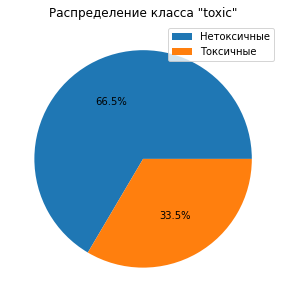

In [ ]:
plt.figure(figsize=(5, 5))
plt.pie(data.toxic.value_counts(), autopct='%1.1f%%')
plt.legend(['Нетоксичные', 'Токсичные'])
plt.title('Распределение класса "toxic"')
plt.show()

Видим, что класс toxic не сбалансирован, поэтому при оценке качества модели мы будем обращать внимание на метрики F1, precision и recall.

## Анализ комментариев

### Токенизация

Начнем работу с комментариями. Загрузим nltk.

In [ ]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

Дополним стопсловарь, а также создадим вайтлист слов, которые небольшие и содержатся в стопсловаре от nltk, но при этом могут существенно поменять смысл предложений.

In [ ]:
STOPWORDS = set(stopwords.words('russian'))
STOPWORDS.update(['это'])
WHITELISTWORDS = set(['нет'])

Превратим наши комментарии в набор токенов. Удалим все небуквенные символы, а также слова из одной буквы.

In [ ]:
import re

def tokenize_text(text, min_word_length=1):
    text = text.lower()
    text = re.sub(r'http\S+', '', text)
    text = re.sub('ё', 'е', text)
    text = re.findall('[а-яё]+', text)
    return [token for token in text if len(token) > min_word_length]

У нас есть два способа приведения слов к их основам: стемминг и лемматизация.

*   **Стемминг.** 

В этом случае алгоритм просто отбрасывает часть букв из слова так, чтобы в итоге осталась только основа. Это быстрый способ, однако неточный, поскольку слабо учитывает тонкости языка. Например, слово 'пила' алгоритм стемминга определит как 'пила', однако на самом деле это слово может быть как существительным, так и глаголом 'пить' в прошедшем времени.
*   **Лемматизация**

Этот алгоритм сложнее и требует сильно больше времени на обработку слов. В этом случае мы не просто выбираем основу у слова (как в стемминге), а приводим слово к его ***лемме*** - нормальной (словарной) форме. Т.е. слово 'пила' может быть как быть приведено и к слову 'пить', в зависимости от части речи этого слова.

Поскольку скорость нам не особо важна и обрабатывать мы будем не огромное количество информации, напишем функцию для лемматизации слов. Используем библиотеку pymorphy2.

In [ ]:
import pymorphy2

lemmatizer  = pymorphy2.MorphAnalyzer()
def lemmatizing(tokens):
    return [lemmatizer.parse(token)[0].normal_form for token in tokens]

2022-07-29 15:05:54,247 : INFO : Loading dictionaries from /usr/local/lib/python3.7/dist-packages/pymorphy2_dicts_ru/data
2022-07-29 15:05:54,338 : INFO : format: 2.4, revision: 417127, updated: 2020-10-11T15:05:51.070345


Фильтруем от стопслов наши токены, игнорируя слова из вайтлиста.

In [ ]:
def delete_stopwords(tokens):
  return ' '.join(list(filter(lambda token:
                              token not in STOPWORDS or token in WHITELISTWORDS, tokens)))

Соединяем все функции очистки данных в одну.

In [ ]:
def clean_data(text):
  tokens = tokenize_text(text)
  tokens = lemmatizing(tokens)
  tokens = delete_stopwords(tokens)
  return tokens

### Распределение слов по частоте

Посмотрим на распределение слов по их количеству и увидим, что удаление стопслов и слишком коротких слов сильно повлияло на распределение.

In [ ]:
from collections import Counter
from tqdm.notebook import tqdm

Функция для подсчета топ-20 слов в колонке таблицы по встречаемости

In [ ]:
def word_counter(column, column_name):
  counter = Counter([word for word in ' '.join(column.values).split()])
  top_twenty = pd.DataFrame(counter.most_common(20))
  top_twenty.columns = pd.MultiIndex.from_product([[column_name], ['word', 'count']])
  return top_twenty

top_twenty_past = word_counter(data.comment, 'До удаления') # сохраняем топ-20 слов до чистки

Чистим данные...

In [ ]:
tqdm.pandas()
data.comment = data.comment.progress_apply(clean_data) # непосредственно сама токенизация

  0%|          | 0/14412 [00:00<?, ?it/s]

Считаем топ слов после чистки, соединяем таблицы и смотрим на результат.

In [ ]:
top_twenty = word_counter(data.comment, 'После удаления')
top_twenty = top_twenty.join(top_twenty_past, how='left')
top_twenty.style.background_gradient(cmap='winter')

### Удаление пустых и дубликатов

Функции для удаления пустых и дублирующихся комментариев, которые могли возникнуть после токенизации. 

***NOTE:*** Все предыдущие функции работали со строками (на вход подавалась строка), а функции ниже работают со всем датафреймом.

In [ ]:
def delete_empty(df):
  empty = df.loc[df.comment == '']
  print('Количество пустых комментариев после токенизации: {}'.format(len(empty)))
  df = df.drop(empty.index)
  return df

In [ ]:
def delete_duplicates(df):
  duplicates = df.duplicated(subset=['comment'])
  print('Количество дублирующих комментариев после токенизации: {}'.format(duplicates.sum()))
  df = df.drop_duplicates(ignore_index=True)
  return df

In [ ]:
data = delete_empty(data)
data = delete_duplicates(data)

Количество пустых комментариев после токенизации: 12
Количество дублирующих комментариев после токенизации: 267


Посмотрим как в итоге у нас выглядят данные на этом этапе.

In [ ]:
data.head(5)

,comment,toxic
0,верблюд дебил бл,1.0
1,хохол отдушина затюканый россиянин мол вон хох...,1.0
2,собака собачий смерть,1.0
3,страница обновить дебил оскорбление доказать ф...,1.0
4,убедить страничный пдф скрипаль отравить росси...,1.0


По словам 'собака' и 'собачий' можно понять, что лемматизация сохранила части речи слов. Возможно, это будет потом мешать, но может и наоборот, помогать.

### Облако слов

In [ ]:
from wordcloud import WordCloud

Построим облако слов нашей выборки для токсичных комментариев и для обычных.

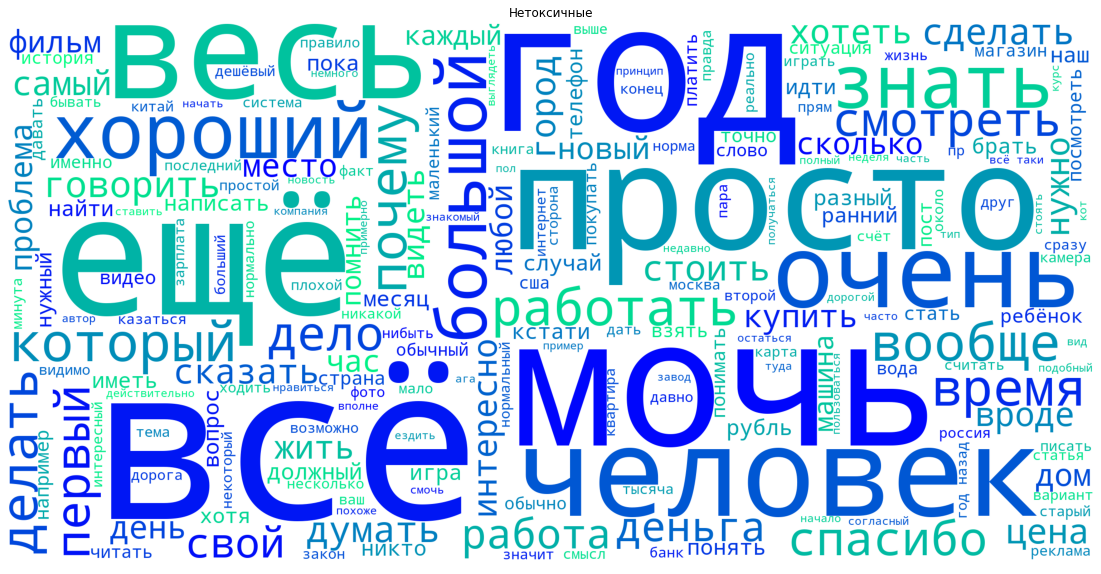

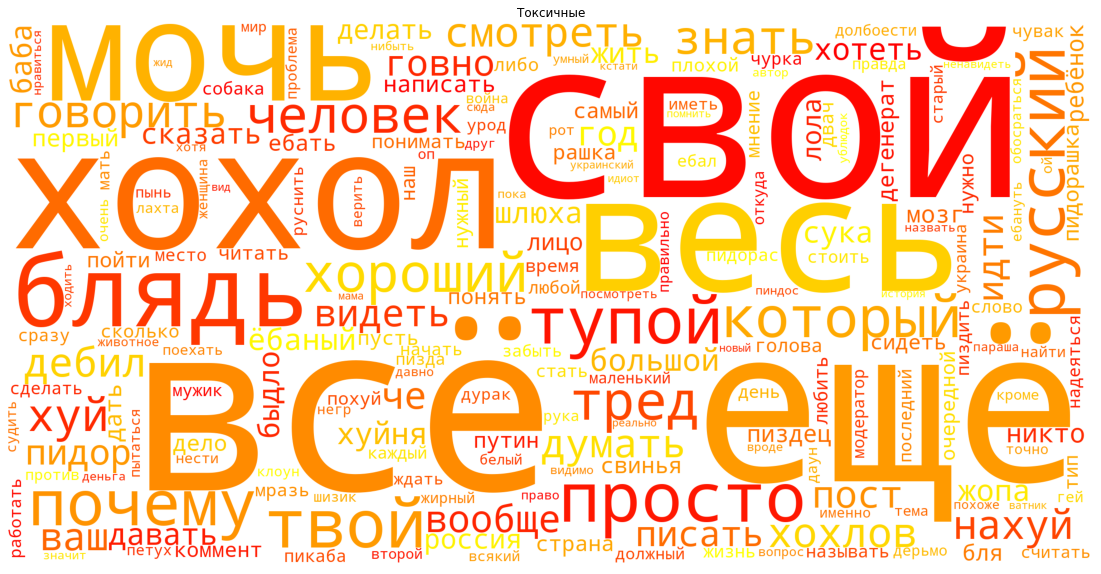

In [ ]:
for i, i_name in enumerate(['Нетоксичные', 'Токсичные']):
    wc = WordCloud(background_color="white", max_words=200, margin=5,
                   width=2400, height=1200, stopwords=STOPWORDS,
                   min_font_size=20, random_state=RANDOM_STATE, colormap=['winter','autumn'][i])
    wc.generate(data.comment[(data.comment.notnull()) & (data.toxic == i)].to_string())
    plt.figure(figsize=(20, 10))
    plt.title(i_name)
    plt.axis("off")
    plt.imshow(wc)

### Длина комментариев

Посмотрим на длину комментариев.

In [ ]:
data.comment_len = data.comment.str.len()
data.comment_len.describe()

count    14178.000000
mean       126.690154
std        205.208054
min          3.000000
25%         39.000000
50%         71.000000
75%        140.000000
max       5929.000000
Name: comment, dtype: float64

Построим графики зависимостей длины токсичных, нетоксичных и всех комментариев от их частоты.

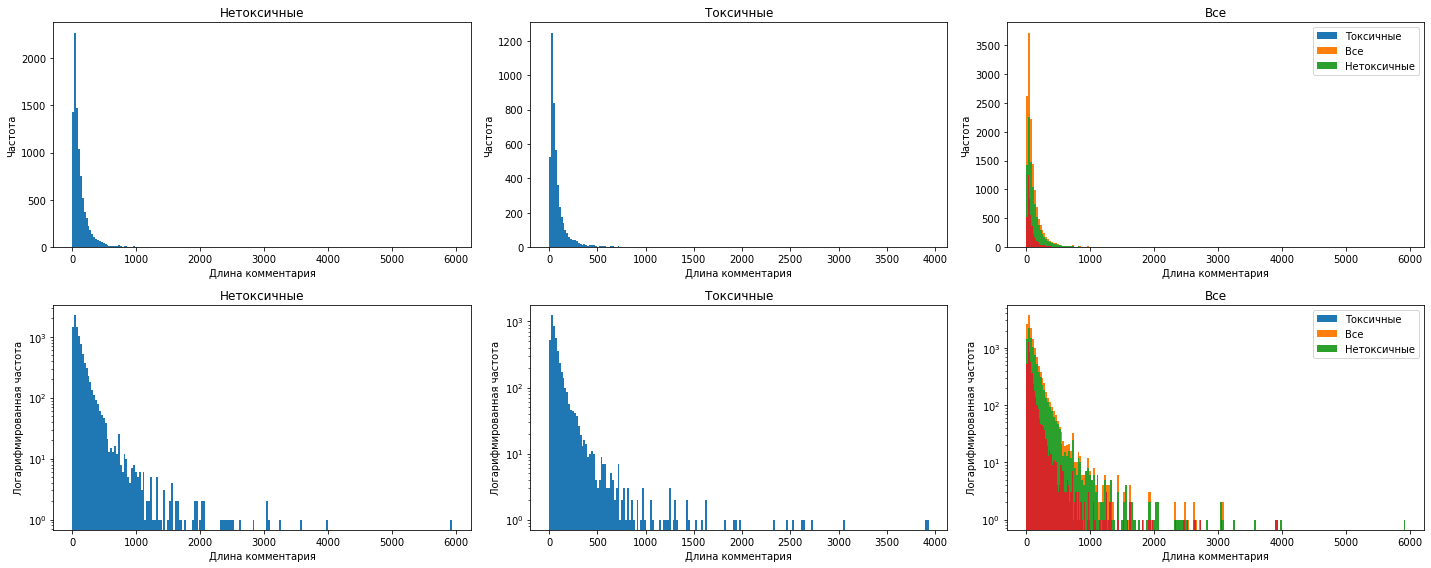

In [ ]:
fig, ax = plt.subplots(2, 3, figsize=(20, 8))
ax = ax.ravel()
for i, name in enumerate(['Нетоксичные', 'Токсичные', 'Все']):
  ax[i].hist(data.comment_len.loc[data.toxic==i], bins=200)
  ax[i+3].hist(data.comment_len.loc[data.toxic==i], bins=200, log=True)
  if name=='Все':
    ax[i].hist(data.comment_len, bins=200)
    ax[i].hist(data.comment_len.loc[data.toxic==0], bins=200)
    ax[i].hist(data.comment_len.loc[data.toxic==1], bins=200)
    ax[i].legend(['Токсичные', 'Все', 'Нетоксичные'])
    ax[i+3].hist(data.comment_len, bins=200, log=True)
    ax[i+3].hist(data.comment_len.loc[data.toxic==0], bins=200, log=True)
    ax[i+3].hist(data.comment_len.loc[data.toxic==1], bins=200, log=True)
    ax[i+3].legend(['Токсичные', 'Все', 'Нетоксичные'])
  ax[i].set(xlabel='Длина комментария', ylabel='Частота', title=name)
  ax[i+3].set(xlabel='Длина комментария', ylabel='Логарифмированная частота', title=name)
plt.tight_layout()

Как видим, длина комментария особо сильно не влияет на токсичность. Вероятнее всего, я **не буду использовать** длину комментария как дополнительный параметр в модели.

# 2. Векторизация

## Разделение выборки на train/test

Итак, наши данные до векторизации (или превращения слов в эмбеддинги) выглядят так:

In [ ]:
data.head()

,comment,toxic
0,верблюд дебил бл,1.0
1,хохол отдушина затюканый россиянин мол вон хох...,1.0
2,собака собачий смерть,1.0
3,страница обновить дебил оскорбление доказать ф...,1.0
4,убедить страничный пдф скрипаль отравить росси...,1.0


Разделим выборку на train и на test в соотношении 2 к 1.

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
data_train, data_test = train_test_split(data, 
                                         random_state=RANDOM_STATE, 
                                         test_size=0.33, 
                                         stratify=data['toxic'])

X_train = data_train['comment'].values
X_test = data_test['comment'].values

y_train = data_train['toxic'].values
y_test = data_test['toxic'].values

## TF-IDF

Превратим слова в векторы по принципу TF-IDF.


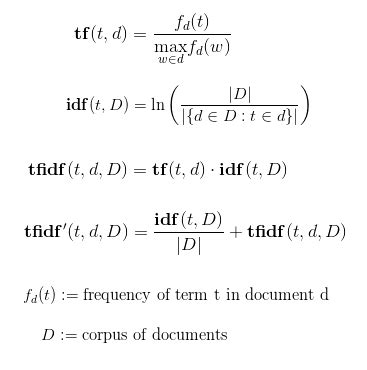

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
tfidf_vectorizer = TfidfVectorizer(ngram_range=(2,4), 
                                   analyzer='char_wb',
                                   max_df=0.8, 
                                   min_df=10)

X_train = tfidf_vectorizer.fit_transform(X_train)
X_test = tfidf_vectorizer.transform(X_test)

print('Total features: ', len(tfidf_vectorizer.get_feature_names()))

Total features:  15397


Посмотрим теперь как в итоге выглядят наши данные.

In [ ]:
X_train[0], y_train[0]

(<1x15397 sparse matrix of type '<class 'numpy.float64'>'
 	with 66 stored elements in Compressed Sparse Row format>, 0.0)

Как видим, все комментарии превратились в векторы.

## Word2Vec

### Определение модели

In [ ]:
import gensim
from gensim.test.utils import common_texts
from gensim.models.word2vec import Word2Vec
from gensim.models import KeyedVectors

2022-07-29 15:48:14,352 : INFO : 'pattern' package not found; tag filters are not available for English
2022-07-29 15:48:14,367 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2022-07-29 15:48:14,370 : INFO : built Dictionary(12 unique tokens: ['computer', 'human', 'interface', 'response', 'survey']...) from 9 documents (total 29 corpus positions)


Подготовим данные так, чтобы они без проблем подходили на вход в токенизатор.

In [ ]:
w2v_X_train = [_.split() for _ in X_train]
w2v_X_test = [_.split() for _ in X_test]
w2v_X_train[:1]

[['полгода', 'год', 'назад', 'никто', 'знать']]

Определим параметры токенизатора.

In [ ]:
vector_size = 300
window = 2
min_count = 1
sample=6e-5
alpha=0.03
min_alpha=0.0007

epochs = 60

И сам токенизатор. А также построим словарь.

In [ ]:
w2v_vectorizer = Word2Vec(min_count=min_count,
                          window=window,
                          size=vector_size,
                          workers=CORES,
                          seed=RANDOM_STATE)

w2v_vectorizer.build_vocab(w2v_X_train)

2022-07-29 15:48:22,603 : INFO : collecting all words and their counts
2022-07-29 15:48:22,606 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2022-07-29 15:48:22,678 : INFO : collected 26013 word types from a corpus of 153389 raw words and 9499 sentences
2022-07-29 15:48:22,682 : INFO : Loading a fresh vocabulary
2022-07-29 15:48:22,756 : INFO : effective_min_count=1 retains 26013 unique words (100% of original 26013, drops 0)
2022-07-29 15:48:22,758 : INFO : effective_min_count=1 leaves 153389 word corpus (100% of original 153389, drops 0)
2022-07-29 15:48:22,855 : INFO : deleting the raw counts dictionary of 26013 items
2022-07-29 15:48:22,858 : INFO : sample=0.001 downsamples 15 most-common words
2022-07-29 15:48:22,861 : INFO : downsampling leaves estimated 149082 word corpus (97.2% of prior 153389)
2022-07-29 15:48:22,998 : INFO : estimated required memory for 26013 words and 300 dimensions: 75437700 bytes
2022-07-29 15:48:23,000 : INFO : resetting laye

Запустим обучение.

In [ ]:
%%time
w2v_vectorizer.train(w2v_X_train, 
                     total_examples=w2v_vectorizer.corpus_count, 
                     epochs=epochs)

2022-07-29 15:48:32,079 : INFO : training model with 2 workers on 26013 vocabulary and 300 features, using sg=0 hs=0 sample=0.001 negative=5 window=2
2022-07-29 15:48:33,046 : INFO : worker thread finished; awaiting finish of 1 more threads
2022-07-29 15:48:33,074 : INFO : worker thread finished; awaiting finish of 0 more threads
2022-07-29 15:48:33,075 : INFO : EPOCH - 1 : training on 153389 raw words (149049 effective words) took 1.0s, 155746 effective words/s
2022-07-29 15:48:34,127 : INFO : EPOCH 2 - PROGRESS: at 91.48% examples, 134463 words/s, in_qsize 2, out_qsize 0
2022-07-29 15:48:34,162 : INFO : worker thread finished; awaiting finish of 1 more threads
2022-07-29 15:48:34,175 : INFO : worker thread finished; awaiting finish of 0 more threads
2022-07-29 15:48:34,178 : INFO : EPOCH - 2 : training on 153389 raw words (149111 effective words) took 1.1s, 140323 effective words/s
2022-07-29 15:48:35,053 : INFO : worker thread finished; awaiting finish of 1 more threads
2022-07-29 1

CPU times: user 54.5 s, sys: 498 ms, total: 55 s
Wall time: 38.7 s


(8945282, 9203340)

Теперь сохраним наши эмбеддинги, чтобы в будущем (на стадии тестирования) обращаться непосредственно к ним, а не к модели.

In [ ]:
w2v_vectorizer.wv.save("word2vec.wordvectors")
# загрузим с параметром memory-mapping=read-only
w2v = KeyedVectors.load("word2vec.wordvectors", mmap='r')

2022-07-29 15:49:35,317 : INFO : saving Word2VecKeyedVectors object under word2vec.wordvectors, separately None
2022-07-29 15:49:35,322 : INFO : not storing attribute vectors_norm
2022-07-29 15:49:36,614 : INFO : saved word2vec.wordvectors
2022-07-29 15:49:36,619 : INFO : loading Word2VecKeyedVectors object from word2vec.wordvectors
2022-07-29 15:49:37,757 : INFO : setting ignored attribute vectors_norm to None
2022-07-29 15:49:37,767 : INFO : loaded word2vec.wordvectors


### Тесты

Проведем несколько тестов наших эмбеддингов.

In [ ]:
def w2v_tests(word1, word2, word3=None):
  if word3:
    doesnt_match = w2v.doesnt_match([word1, word2, word3])
    return print(f"Среди '{word1}', '{word2}' и '{word3}' лишнее слово - '{doesnt_match}'")
  print(f"'{word1}' и '{word2}' схожи на {100*w2v.similarity(word1, word2):.2f}%")
  most_similar = w2v.most_similar(positive=[word1], negative=[word2], topn=1)
  print(f"'{word1}' без '{word2}' схоже со словом '{most_similar[0][0]}' на {100*most_similar[0][1]:.2f}%")

In [ ]:
w2v_tests('мужчина', 'женщина')
w2v_tests('женщина', 'посудомойка')
w2v_tests('мужчина', 'женщина')
w2v_tests('мужчина', 'женщина', 'любить')

2022-07-29 15:49:44,375 : INFO : precomputing L2-norms of word weight vectors


'мужчина' и 'женщина' схожи на 65.23%
'мужчина' без 'женщина' схоже со словом 'двухвыводной' на 36.40%
'женщина' и 'посудомойка' схожи на 22.38%
'женщина' без 'посудомойка' схоже со словом 'мужчина' на 32.97%
'мужчина' и 'женщина' схожи на 65.23%
'мужчина' без 'женщина' схоже со словом 'двухвыводной' на 36.40%
Среди 'мужчина', 'женщина' и 'любить' лишнее слово - 'любить'


In [ ]:
w2v.most_similar(positive=['мужчина'])

[('поздравление', 0.6849284768104553),
 ('ненец', 0.6736175417900085),
 ('угнетптеть', 0.664975643157959),
 ('женщина', 0.6522952318191528),
 ('сношаться', 0.628358006477356),
 ('привилегия', 0.6230000257492065),
 ('хиджаб', 0.6137920618057251),
 ('лошка', 0.6125326156616211),
 ('пидоресс', 0.6061782836914062),
 ('поднимаетс', 0.6022597551345825)]

### Эмбеддинги комментариев

На этом этапе мы имеет векторное представление каждого слова.

In [ ]:
w2v['мужчина'][:10]

array([-0.42023888, -0.20288327,  0.38885725,  0.6481178 ,  0.04358425,
       -0.72464055,  0.31114063,  0.45547765,  0.31307122,  0.09165791],
      dtype=float32)

Давайте для каждого комментария просуммируем эмбеддинги всех его слов.

In [ ]:
def build_embeddings(data):
  embeddings = []
  for comment in data:
    sum_comment = np.zeros(vector_size)
    for word in comment.split():
      try: sum_comment += w2v[word]
      except: pass # конструкция для предотвращения ошибок отсутствия слова в словаре
    embeddings.append(sum_comment)
  return embeddings

In [ ]:
%%time
X_train = build_embeddings(X_train)
X_test = build_embeddings(X_test)

CPU times: user 1.13 s, sys: 11.2 ms, total: 1.14 s
Wall time: 1.15 s


In [ ]:
len(X_train), len(X_train[0]), len(X_test), len(X_test[0])

(9499, 300, 4679, 300)

Эмбеддинги готовы, можно обучать на них модели

## FastText

### Определение модели

Сначала загрузим нашу модель. Я использовал модель `geowac_tokens_none_fasttextskipgram_300_5_2020` с сайта [RusVectores](https://rusvectores.org/ru/models/). Дата создания модели - Октябрь 2020. Всю остальную информацию можно найти у них на сайте.

In [ ]:
import gensim
from gensim.models import KeyedVectors
import wget

In [ ]:
!wget http://vectors.nlpl.eu/repository/20/214.zip
!unzip 214.zip
!rm 214.zip

--2022-07-29 15:50:58--  http://vectors.nlpl.eu/repository/20/214.zip
Resolving vectors.nlpl.eu (vectors.nlpl.eu)... 129.240.189.181
Connecting to vectors.nlpl.eu (vectors.nlpl.eu)|129.240.189.181|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1920218982 (1.8G) [application/zip]
Saving to: ‘214.zip’

214.zip             100%[===================>]   1.79G  10.2MB/s    in 3m 5s   

2022-07-29 15:54:05 (9.89 MB/s) - ‘214.zip’ saved [1920218982/1920218982]

Archive:  214.zip
  inflating: meta.json               
  inflating: model.model             
  inflating: model.model.vectors_ngrams.npy  
  inflating: model.model.vectors.npy  
  inflating: model.model.vectors_vocab.npy  
  inflating: README                  


In [ ]:
w2v_vectorizer_pretrained = KeyedVectors.load("model.model", mmap='r') # read-only
w2v_vectorizer_pretrained.vector_size, len(w2v_vectorizer_pretrained.wv.vocab)

2022-07-29 15:54:30,305 : INFO : loading Word2VecKeyedVectors object from model.model
2022-07-29 15:54:31,842 : INFO : loading vectors from model.model.vectors.npy with mmap=r
2022-07-29 15:54:31,848 : INFO : loading vectors_vocab from model.model.vectors_vocab.npy with mmap=r
2022-07-29 15:54:31,852 : INFO : loading vectors_ngrams from model.model.vectors_ngrams.npy with mmap=r
2022-07-29 15:54:31,856 : INFO : setting ignored attribute vectors_norm to None
2022-07-29 15:54:31,857 : INFO : setting ignored attribute vectors_vocab_norm to None
2022-07-29 15:54:31,859 : INFO : setting ignored attribute vectors_ngrams_norm to None
2022-07-29 15:54:31,862 : INFO : setting ignored attribute buckets_word to None
2022-07-29 15:54:31,863 : INFO : loaded model.model


(300, 347295)

### Тесты

Проведем несколько тестов

In [ ]:
w2v_vectorizer_pretrained.most_similar_to_given('женщина', ['человек', 'посудомойка', 'дерево'])

'человек'

In [ ]:
w2v_vectorizer_pretrained.similarity('женщина', 'посудомойка')

0.31115994

In [ ]:
w2v_vectorizer_pretrained.most_similar('женщина')

2022-07-29 15:54:31,897 : INFO : precomputing L2-norms of word weight vectors
2022-07-29 15:54:32,796 : INFO : precomputing L2-norms of ngram weight vectors


[('девушка', 0.8526571393013),
 ('дама', 0.7701615691184998),
 ('девочка', 0.7535508871078491),
 ('родительница', 0.731643795967102),
 ('.женщина', 0.7311210632324219),
 ('юница', 0.7193236947059631),
 ('женка', 0.7139725089073181),
 ('-женщина', 0.7134703397750854),
 ('старушка', 0.7118268609046936),
 ('пожилая', 0.7090767621994019)]

Посмотрим, как выглядят эмбеддинги слов.

In [ ]:
w2v_vectorizer_pretrained['женщина'][:10]

memmap([ 0.21637547,  0.07873943,  0.03028277,  0.09389011, -0.19737758,
        -0.12343895,  0.19984819,  0.3069581 ,  0.11994553, -0.1134624 ],
       dtype=float32)

### Эмбеддинги комментариев

Сейчас наши данные выглядят так:

In [ ]:
X_train[:10]

array(['полгода год назад никто знать',
       'дать ещё написать ошибка море исправить молодец ещё идея дополнить фанера вырезать провод полоска фикс прайс брать светильник длинный диод проводы шкаф пример красиво подсветка выключатель нибыть бок сзади кнопка переключатель стена',
       'раздражать фасадный краска тиккурить тиккурилы крыть фасадный краска дерево вид всё разный',
       'баба копия подруга питер рука сломать',
       'говорить прочесть вкратце специалист предлагать начать принимать ряд мера безопасно выпустить вообще говорить пример успешный адаптация идея всё норма чудом удаться заставить хапуга выпустить лапа плавучий миллион доллар',
       'виза дебет кредит бесконтактный платить транспорт',
       'убогий говнюк повезти жизнь кругом говно наркоман живить далёкий злобствовать плеваться свой ядовитый слюна большой жёлчь вырабатывать быстрый сдохнуть',
       'полно дебил незнающий тема', 'маска лепесток короче',
       'делать выбор нет верить манямирок коллапсиров

Дальнейшая процедура подготовки аналогична процедуре подготовки в разделе Word2Vec.

In [ ]:
w2v_X_train = [_.split() for _ in X_train]
w2v_X_test = [_.split() for _ in X_test]
w2v_X_train[:1]

[['полгода', 'год', 'назад', 'никто', 'знать']]

In [ ]:
def build_embeddings(data):
  vector_size = 300
  embeddings = []
  for comment in data:
    sum_comment = np.zeros(vector_size)
    for word in comment.split():
      try: sum_comment += w2v_vectorizer_pretrained[word]
      except: pass
    embeddings.append(sum_comment)
  return embeddings

In [ ]:
%%time
X_train = build_embeddings(X_train)
X_test = build_embeddings(X_test)

CPU times: user 2.83 s, sys: 89.3 ms, total: 2.92 s
Wall time: 2.9 s


In [ ]:
len(X_train), len(X_train[0]), len(X_test), len(X_test[0])

(9499, 300, 4679, 300)

## BERT

In [ ]:
from transformers import AutoTokenizer, AutoModel

Импортируем готовую реализацию [rubert-tiny](https://huggingface.co/cointegrated/rubert-tiny).

In [ ]:
bert_tokenizer = AutoTokenizer.from_pretrained("cointegrated/rubert-tiny")
bert_model = AutoModel.from_pretrained("cointegrated/rubert-tiny")
if DEVICE=='cuda': bert_model.cuda()

Some weights of the model checkpoint at cointegrated/rubert-tiny were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Напишем свой класс для удобства.

In [ ]:
class BertVectorizer():
    def __init__(self, model, tokenizer):
      self.model = model
      self.tokenizer = tokenizer

    def transform(self, text):
        t = self.tokenizer(text, padding=True, truncation=True, return_tensors='pt')
        with torch.no_grad():
            model_output = self.model(**t)
        embeddings = model_output.pooler_output
        embeddings = torch.nn.functional.normalize(embeddings)
        return embeddings[0]

bert_vectorizer = BertVectorizer(bert_model, bert_tokenizer)
bert_vectorizer.transform('я люблю виноград').shape

torch.Size([312])

In [ ]:
%%time
X_train = torch.stack([bert_vectorizer.transform(comment) for comment in data_train.comment])
X_test = torch.stack([bert_vectorizer.transform(comment) for comment in data_test.comment])

CPU times: user 2min 16s, sys: 3.74 s, total: 2min 19s
Wall time: 2min 19s


# 3. Моделлинг

В этой части мы обозначим все модели, которые будем использовать, обучим их (или загрузим уже предобученные) и подберем нужные параметры. Тестироваться модели в данном разделе будут, но каждая в одиночном порядке. Общие тесты всех моделей будут в разделе **Оценка качества моделей**.

Импортируем нужные библиотеки.

In [ ]:
import torch.nn.functional as F
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, plot_confusion_matrix, plot_roc_curve
from sklearn.metrics import precision_recall_fscore_support, precision_score, recall_score
from sklearn.metrics import precision_recall_curve, plot_precision_recall_curve
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier

Создадим таблицу для сбора метрик с моделей.

In [ ]:
metrics = pd.DataFrame(columns=['Модель', 'P1', 'R1', 'P0', 'R0', 'AP', 'AR', 'F1'])

Мы хотим значение метрики `precision` класса `1` не меньше 0.90, поскольку нам важно, чтобы модель практически не определяла нетоксичные комментарии, как токсичные. При таком `precision` нам надо максимизировать `recall`.

## SISmetanin

Используем готовые [модель и токенизатор](https://huggingface.co/sismetanin/rubert-toxic-pikabu-2ch).

***NOTE:*** **В этой модели не используются токенайзеры, описываемые выше (TF-IDF, Word2Vec, FastText, BERT). Эта модель имеет свой встроенный токенайзер.**

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer_sismetanin = AutoTokenizer.from_pretrained("sismetanin/rubert-toxic-pikabu-2ch")
model_sismetanin = AutoModelForSequenceClassification.from_pretrained("sismetanin/rubert-toxic-pikabu-2ch")

## Skolkovo

На портале Hugging Face я нашел замечательную [модель](https://huggingface.co/SkolkovoInstitute/russian_toxicity_classifier?text=Ты+мне+нравишься.+Я+тебя+люблю) от Института Сколково. Она была обучена на моем датасете, а также на еще одном датасете. Модель основана на трансформере BERT. Вся информация по этому поводу есть у них на Hugging Face.

***NOTE:*** **В этой модели не используются токенайзеры, описываемые выше (TF-IDF, Word2Vec, FastText, BERT). Эта модель имеет свой встроенный токенайзер.**

In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification

# загружаем сразу и токенайзер и веса модели
tokenizer_skolkovo = BertTokenizer.from_pretrained('SkolkovoInstitute/russian_toxicity_classifier')
model_skolkovo = BertForSequenceClassification.from_pretrained('SkolkovoInstitute/russian_toxicity_classifier')

## Logistic regression

Обычная регрессия, ничего интересного.

### GridSearchCV

Построим обычную логистическую регрессию и посмотрим на ее параметры.

In [ ]:
model_logreg = LogisticRegression(random_state=RANDOM_STATE)
model_logreg.get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': 42,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

Сделаем решетку параметров, чтобы найти оптимальные.

In [ ]:
parameters = {'C': (3, 5, 7),
              'class_weight': (None, 'balanced'),
              'max_iter': (100, 500, 1000),
              'warm_start': (True, False),
              'penalty': ('l1','l2','elasticnet')}

In [ ]:
%%time
model_logreg_gs = GridSearchCV(model_logreg, parameters, scoring='f1', cv=5, n_jobs=-1)
model_logreg_gs.fit(X_train, y_train)
print(model_logreg_gs.best_params_)

{'C': 3, 'class_weight': 'balanced', 'max_iter': 100, 'penalty': 'l2', 'warm_start': True}
CPU times: user 3.28 s, sys: 973 ms, total: 4.25 s
Wall time: 1min 48s


### Лучшая модель

In [ ]:
model_logreg = LogisticRegression(C=5, 
                                  class_weight='balanced',
                                  max_iter=1000, 
                                  penalty='l2',
                                  warm_start=True, 
                                  random_state=RANDOM_STATE)
model_logreg.fit(X_train, y_train)
print(classification_report(y_test, model_logreg.predict(X_test)))

              precision    recall  f1-score   support

         0.0       0.92      0.92      0.92      3116
         1.0       0.83      0.84      0.84      1563

    accuracy                           0.89      4679
   macro avg       0.88      0.88      0.88      4679
weighted avg       0.89      0.89      0.89      4679



Добавим метрики в таблицу

In [ ]:
AP, AR, F1, _ = precision_recall_fscore_support(y_test, model_logreg.predict(X_test), average='weighted')
(P0, P1), (R0, R1), _, _ = precision_recall_fscore_support(y_test, model_logreg.predict(X_test), average=None)
metrics.loc[len(metrics)]=('LogRegression', P1, R1, P0, R0, AP, AR, F1)

### Визуализация результатов

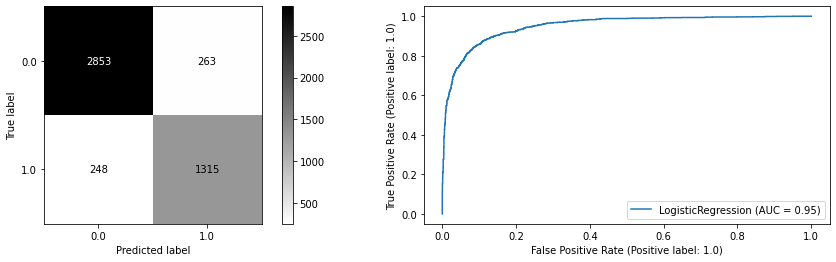

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(16, 4))
plot_confusion_matrix(model_logreg, X_test, y_test, cmap='binary', ax=ax[0])
plot_roc_curve(model_logreg, X_test, y_test, ax=ax[1])
plt.show()

## SVM

Метод Опорных Векторов (Support Vector Machine). 

### GridSearchCV

Построим обычный SVM и посмотрим на его параметры. 

*NOTE:* LinearSVC расшифровывается как Linear Support Vector Classification.

In [ ]:
model_svc = LinearSVC(random_state=RANDOM_STATE)
model_svc.get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': True,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'loss': 'squared_hinge',
 'max_iter': 1000,
 'multi_class': 'ovr',
 'penalty': 'l2',
 'random_state': 42,
 'tol': 0.0001,
 'verbose': 0}

Сделаем решетку параметров, чтобы найти оптимальные.

In [ ]:
parameters = {'C': (3, 5, 7),  
              'max_iter': (100, 500, 1000),
              'class_weight': (None, 'balanced'),
              'penalty': ('l1','l2')}

In [ ]:
%%time
model_svc_gs = GridSearchCV(model_svc, parameters, scoring='f1', cv=5, n_jobs=-1)
model_svc_gs.fit(X_train, y_train)
print(model_svc_gs.best_params_)

{'C': 3, 'class_weight': 'balanced', 'max_iter': 100, 'penalty': 'l2'}
CPU times: user 1.62 s, sys: 90.4 ms, total: 1.71 s
Wall time: 52 s


### Лучшая модель

In [ ]:
model_svc = LinearSVC(C=3, 
                      class_weight='balanced',
                      max_iter=100, 
                      penalty='l2',
                      random_state=RANDOM_STATE)
model_svc.fit(X_train, y_train)
print(classification_report(y_test, model_svc.predict(X_test)))

              precision    recall  f1-score   support

         0.0       0.90      0.91      0.91      3116
         1.0       0.82      0.81      0.81      1563

    accuracy                           0.88      4679
   macro avg       0.86      0.86      0.86      4679
weighted avg       0.87      0.88      0.88      4679



Добавим метрики в таблицу

In [ ]:
AP, AR, F1, _ = precision_recall_fscore_support(y_test, model_svc.predict(X_test), average='weighted')
(P0, P1), (R0, R1), _, _ = precision_recall_fscore_support(y_test, model_svc.predict(X_test), average=None)
metrics.loc[len(metrics)]=('SVM', P1, R1, P0, R0, AP, AR, F1)

### Визуализация результатов

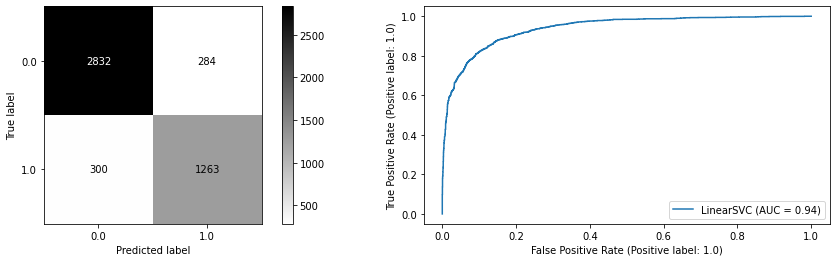

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(16, 4))
plot_confusion_matrix(model_svc, X_test, y_test, cmap='binary', ax=ax[0])
plot_roc_curve(model_svc, X_test, y_test, ax=ax[1])
plt.show()

## SGDClassifier

Линейные классификаторы (SVM, logistic regression, и т.д.) с SGD обучением.

### GridSearchCV

In [ ]:
model_sgd = SGDClassifier(random_state=RANDOM_STATE)
model_sgd.get_params()

{'alpha': 0.0001,
 'average': False,
 'class_weight': None,
 'early_stopping': False,
 'epsilon': 0.1,
 'eta0': 0.0,
 'fit_intercept': True,
 'l1_ratio': 0.15,
 'learning_rate': 'optimal',
 'loss': 'hinge',
 'max_iter': 1000,
 'n_iter_no_change': 5,
 'n_jobs': None,
 'penalty': 'l2',
 'power_t': 0.5,
 'random_state': 42,
 'shuffle': True,
 'tol': 0.001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

Сделаем решетку параметров, чтобы найти оптимальные.

In [ ]:
parameters = {'alpha':(1e-4, 1e-3),
              'eta0': (0, 1e-3),
              'max_iter': (100, 500, 1000),
              'early_stopping': (True, False),
              'average': (True, False),
              'warm_start': (True, False),
              'epsilon': (0.1, 1e-3)}

In [ ]:
%%time
model_sgd_gs = GridSearchCV(model_sgd, parameters, scoring='f1', cv=5, n_jobs=-1)
model_sgd_gs.fit(X_train, y_train)
print(model_sgd_gs.best_params_)

{'alpha': 0.0001, 'average': True, 'early_stopping': False, 'epsilon': 0.1, 'eta0': 0, 'max_iter': 100, 'warm_start': True}
CPU times: user 5.27 s, sys: 458 ms, total: 5.73 s
Wall time: 1min 29s


### Лучшая модель

In [ ]:
model_sgd = SGDClassifier(alpha=0.0001,
                          average=True,
                          class_weight='balanced',
                          early_stopping=False,
                          epsilon=0.1,
                          eta0=0,
                          loss='squared_hinge',
                          max_iter=100,
                          penalty='l2',
                          warm_start=True,
                          random_state=RANDOM_STATE)
model_sgd.fit(X_train, y_train)
print(classification_report(y_test, model_sgd.predict(X_test)))

              precision    recall  f1-score   support

         0.0       0.89      0.91      0.90      3116
         1.0       0.81      0.77      0.79      1563

    accuracy                           0.86      4679
   macro avg       0.85      0.84      0.84      4679
weighted avg       0.86      0.86      0.86      4679



Добавим метрики в таблицу

In [ ]:
AP, AR, F1, _ = precision_recall_fscore_support(y_test, model_sgd.predict(X_test), average='weighted')
(P0, P1), (R0, R1), _, _ = precision_recall_fscore_support(y_test, model_sgd.predict(X_test), average=None)
metrics.loc[len(metrics)]=('SGDClassifier', P1, R1, P0, R0, AP, AR, F1)

### Визуализация результатов

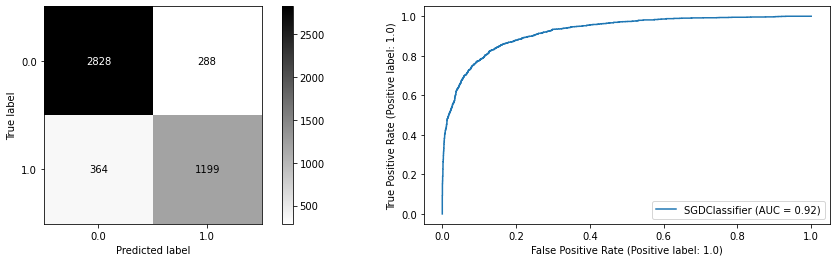

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(16, 4))
plot_confusion_matrix(model_sgd, X_test, y_test, cmap='binary', ax=ax[0])
plot_roc_curve(model_sgd, X_test, y_test, ax=ax[1])
plt.show()

## Naive Bayes

Простая реализация алгоритма наивного Байеса. 

**Не работает в сочетании с BERT, Word2Vec и FastText векторизациями из-за отрицательных значений!**

### GridSearchCV

In [ ]:
model_nb = MultinomialNB()
model_nb.get_params()

{'alpha': 1.0, 'class_prior': None, 'fit_prior': True}



> alpha - параметр аддитивного сглаживания Лапласа/Лидстоуна.



In [ ]:
parameters = {'alpha':(0, 1e-3, 1e-2, 0.1, 0.5, 0.8, 1)}

In [ ]:
%%time
model_nb_gs = GridSearchCV(model_nb, parameters, scoring='f1', cv=5, n_jobs=-1)
model_nb_gs.fit(X_train, y_train)
print(model_nb_gs.best_params_)

{'alpha': 0.1}
CPU times: user 144 ms, sys: 32.9 ms, total: 177 ms
Wall time: 1.2 s


### Лучшая модель

Байес не работает с отрицательными значениями, поэтому не будем его применять, когда у нас после векторизации возникли отрицательные значения эмбеддингов.

*NOTE:* применение сигмоиды сломало модель и она стала предсказывать только класс '0'.

In [ ]:
is_ready = True
X_train_iter = iter(X_train)
for _ in range(10): # проверим только первые 10 элементов, т.к. этого хватит, чтобы
                    # понять есть отрицательные значения в эмбеддингах или их нет
    try: 
      if min(next(X_train_iter))<0: is_ready=False; break
    except: 
      if next(X_train_iter).min()<0: is_ready=False; break

In [ ]:
if is_ready:
  model_nb = MultinomialNB(alpha=0.1)
  model_nb.fit(X_train, y_train)
  # добавим метрики в таблицу
  AP, AR, F1, _ = precision_recall_fscore_support(y_test, model_nb.predict(X_test), average='weighted')
  (P0, P1), (R0, R1), _, _ = precision_recall_fscore_support(y_test, model_nb.predict(X_test), average=None)
  metrics.loc[len(metrics)]=('NaiveBayes', P1, R1, P0, R0, AP, AR, F1)

  print(classification_report(y_test, model_nb.predict(X_test)))

              precision    recall  f1-score   support

         0.0       0.89      0.95      0.92      3116
         1.0       0.89      0.76      0.82      1563

    accuracy                           0.89      4679
   macro avg       0.89      0.86      0.87      4679
weighted avg       0.89      0.89      0.89      4679



### Визуализация результатов

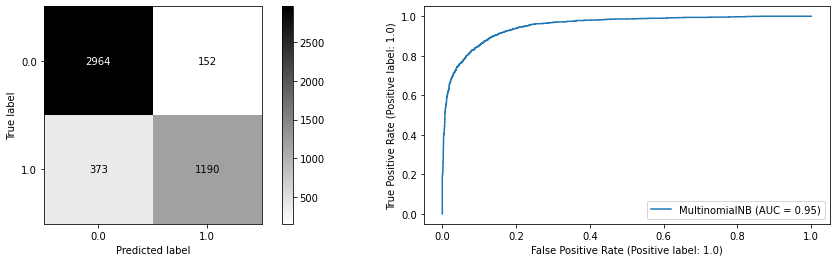

In [ ]:
if is_ready:
  fig, ax = plt.subplots(1, 2, figsize=(16, 4))
  plot_confusion_matrix(model_nb, X_test, y_test, cmap='binary', ax=ax[0])
  plot_roc_curve(model_nb, X_test, y_test, ax=ax[1])
  plt.show()

## RandomForest

Обычный случайный лес деревьев решений, ничего интересного.

### GridSearchCV

In [ ]:
model_rf = RandomForestClassifier(random_state=RANDOM_STATE)
model_rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

Сделаем решетку параметров, чтобы найти оптимальные.

In [ ]:
parameters = {'n_estimators': (300, 500, 800),
              'min_samples_split': (2, 3)}

In [ ]:
%%time
model_rf_gs = GridSearchCV(model_rf, parameters, scoring='f1', cv=5, n_jobs=-1)
model_rf_gs.fit(X_train, y_train)
print(model_rf_gs.best_params_)

{'min_samples_split': 3, 'n_estimators': 300}
CPU times: user 1min 14s, sys: 1.45 s, total: 1min 16s
Wall time: 31min 37s


### Лучшая модель

In [ ]:
model_rf = RandomForestClassifier(n_estimators=300,
                                  min_samples_split=3,
                                  random_state=RANDOM_STATE)
model_rf.fit(X_train, y_train)
print(classification_report(y_test, model_rf.predict(X_test)))

              precision    recall  f1-score   support

         0.0       0.80      0.97      0.88      3116
         1.0       0.91      0.52      0.66      1563

    accuracy                           0.82      4679
   macro avg       0.85      0.75      0.77      4679
weighted avg       0.84      0.82      0.81      4679



Добавим метрики в таблицу

In [ ]:
AP, AR, F1, _ = precision_recall_fscore_support(y_test, model_rf.predict(X_test), average='weighted')
(P0, P1), (R0, R1), _, _ = precision_recall_fscore_support(y_test, model_rf.predict(X_test), average=None)
metrics.loc[len(metrics)]=('RandomForest', P1, R1, P0, R0, AP, AR, F1)

### Визуализация результатов

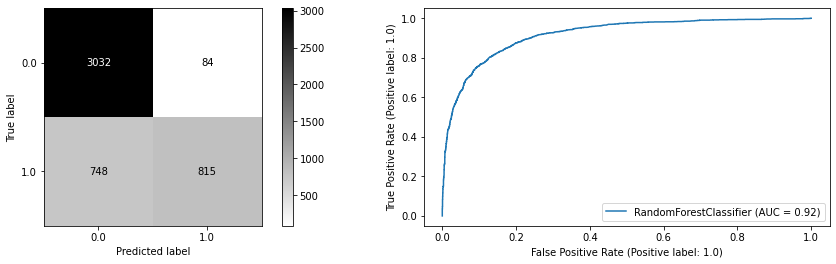

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(16, 4))
plot_confusion_matrix(model_rf, X_test, y_test, cmap='binary', ax=ax[0])
plot_roc_curve(model_rf, X_test, y_test, ax=ax[1])
plt.show()

# 4. Оценка качества моделей

***NOTE:*** **В этом разделе тестируются только модели из библиотеки scikit-learn.**

Таблица со всеми интересующими нас метриками моделей.

In [ ]:
metrics

,Модель,P1,R1,P0,R0,AP,AR,F1
0,LogRegression,0.833333,0.841331,0.920026,0.915597,0.891067,0.890789,0.890918
1,SVM,0.816419,0.808061,0.904215,0.908858,0.874887,0.875187,0.875026
2,SGDClassifier,0.806321,0.767115,0.885965,0.907574,0.859360,0.860654,0.859757
3,NaiveBayes,0.886736,0.761356,0.888223,0.951220,0.887726,0.887797,0.885450
4,RandomForest,0.906563,0.521433,0.802116,0.973042,0.837006,0.822184,0.806767


Построим общий график roc-auc для всех моделей.

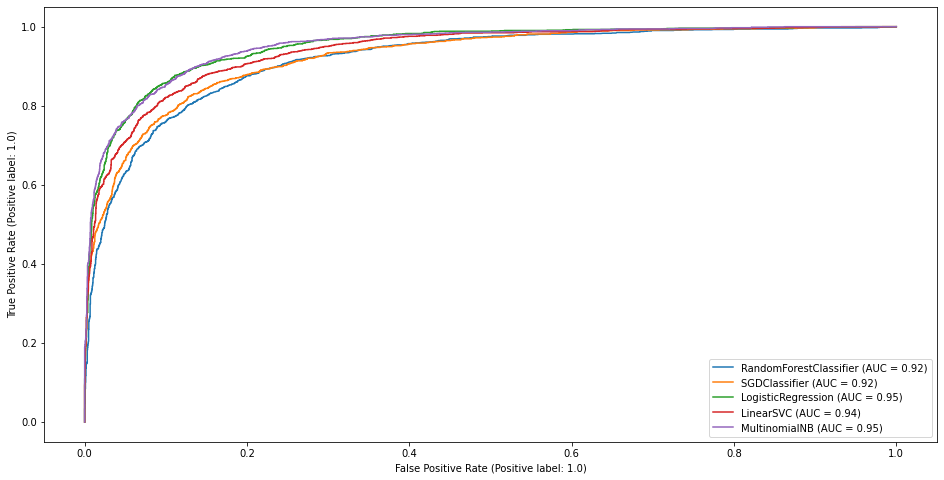

In [ ]:
plt.rcParams["figure.figsize"] = (16, 8) # Сделаем картинку больше для лучшей видимости
ax = plt.gca()
def plot_roc_curve_by_model(model):
  try: plot_roc_curve(model, X_test, y_test, ax=ax)
  except: pass
plot_roc_curve_by_model(model_rf)
plot_roc_curve_by_model(model_sgd)
plot_roc_curve_by_model(model_logreg)
plot_roc_curve_by_model(model_svc)
plot_roc_curve_by_model(model_nb)
plt.show()

Будем выбирать модель с `precision` > 0.90 и максимальным `recall`. 

In [ ]:
p_threshold = 0.90

Визуализируем `precision - recall` кривые

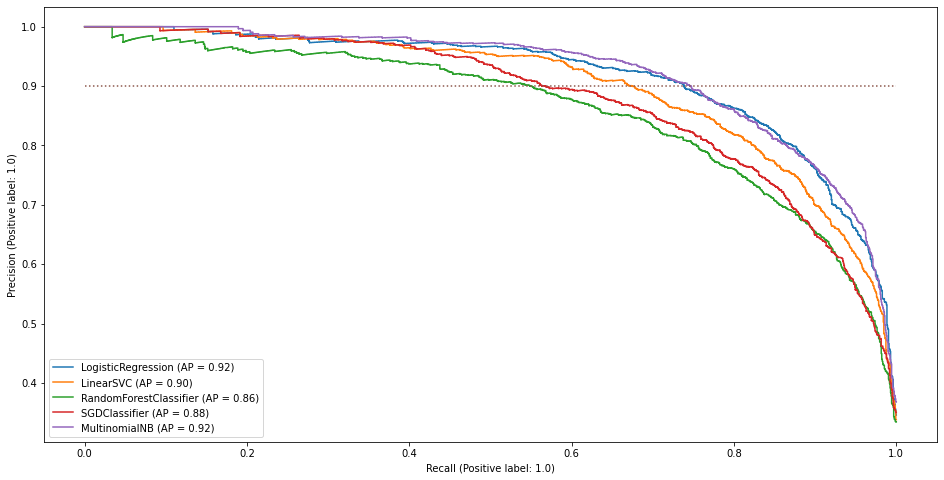

In [ ]:
ax = plt.gca()
def plot_pr_curve(model):
  try: plot_precision_recall_curve(model, X_test, y_test, ax=ax)
  except: pass # тут мог не пройти байес, поэтому try-except
for model in (model_logreg, model_svc, model_rf, model_sgd, model_nb):
  plot_pr_curve(model)
ax.plot([p_threshold, p_threshold], linestyle='dotted')
plt.show()

Теперь выберем лучшую модель (у который максимальный `recall` при `precision` > 0.90

In [ ]:
models = (model_svc, model_rf, model_sgd, model_logreg, model_nb)
best_recall, best_model = 0, None
for model in models:
  try: preds = model.predict_proba(X_test)[:, 1]
  except: preds = model._predict_proba_lr(X_test)[:, 1] # у некоторых моделей нет функции predict_proba, но есть аналогичная _predict_proba_lr
  p, r, thrs = precision_recall_curve(y_test, preds) # p - precision, r - recall, thrs - thresholds
  min_idx_p = np.where(p>p_threshold)[0][0]
  cur_recall = recall_score(y_test, preds > thrs[min_idx_p-1])
  best_recall, best_model = (cur_recall, model) if cur_recall > best_recall else (best_recall, best_model)
print(f'Лучшая модель: {best_model}\nЕё recall: {best_recall}')

Лучшая модель: MultinomialNB(alpha=0.1)
Её recall: 0.7472808701215611


Вернем размеры картинок обратно.

In [ ]:
plt.rcParams["figure.figsize"] = (6, 4)

# 5. Тестирование

Протестируем модели на различных сообщениях

In [ ]:
messages = iter(['привет, как дела?',                           # Easy non-toxic
                 'пошел нахрен',                                # Easy toxic
                 'прекрасный пример полного отсутствия мозга',  # Hard toxic
                 'да закрой рот',                               # Hard toxic
                 'слышь ты, чертила подзаборная'])                              

## Тесты всех моделей

### Получение результатов моделей

Создадим общую таблицу всех результатов и выберем следующую фразу из списка *messages* для проверки.

In [ ]:
results = pd.DataFrame(columns=['Модель', 'Уровень токсичности, %', 'Вердикт'])
message = next(messages)

Зададим способ создания эмбеддингов слов

In [ ]:
vectorizers = (tfidf_vectorizer, 
               bert_vectorizer, 
               KeyedVectors.load("word2vec.wordvectors", mmap='r'), 
               KeyedVectors.load("model.model", mmap='r'))

vectorizer = vectorizers[0]

2022-07-29 16:29:12,209 : INFO : loading Word2VecKeyedVectors object from word2vec.wordvectors
2022-07-29 16:29:13,029 : INFO : setting ignored attribute vectors_norm to None
2022-07-29 16:29:13,053 : INFO : loaded word2vec.wordvectors
2022-07-29 16:29:13,058 : INFO : loading Word2VecKeyedVectors object from model.model
2022-07-29 16:29:15,062 : INFO : loading vectors from model.model.vectors.npy with mmap=r
2022-07-29 16:29:15,071 : INFO : loading vectors_vocab from model.model.vectors_vocab.npy with mmap=r
2022-07-29 16:29:15,076 : INFO : loading vectors_ngrams from model.model.vectors_ngrams.npy with mmap=r
2022-07-29 16:29:15,082 : INFO : setting ignored attribute vectors_norm to None
2022-07-29 16:29:15,088 : INFO : setting ignored attribute vectors_vocab_norm to None
2022-07-29 16:29:15,090 : INFO : setting ignored attribute vectors_ngrams_norm to None
2022-07-29 16:29:15,091 : INFO : setting ignored attribute buckets_word to None
2022-07-29 16:29:15,094 : INFO : loaded model.mod

Превратим все комментарии в эмбеддинги. Тут нужна отдельная функция, потому что каждый токенайзер по-своему превращает.

In [ ]:
def get_embeddings(token, vectorizer) -> list:
  if isinstance(token, (list, np.ndarray, torch.Tensor)):
    token = token[0] # потому что разрешен только один комментарий!
  if isinstance(vectorizer, (gensim.models.keyedvectors.FastTextKeyedVectors,
                             gensim.models.keyedvectors.Word2VecKeyedVectors)):
    sum_comment = np.zeros(vector_size)
    for word in token.split():
      try: sum_comment += vectorizer[word]
      except: pass # конструкция для предотвращения ошибок отсутствия слова в словаре
    return [sum_comment]
  else:
    token = vectorizer.transform([token])
    if isinstance(token, torch.Tensor): token=[token.tolist()] # просто проверка на лист
    return token

In [ ]:
token = clean_data(message)
token = get_embeddings(token, vectorizer)

#### Результаты SISmetanin

In [ ]:
input = tokenizer_sismetanin(message, return_tensors="pt")
output = F.softmax(model_sismetanin(**input).logits.data, dim=1)[0, 1] # берем из выходов только вероятность токсичности
results.loc[len(results)]=('SISmetanin',
                           np.round(float(output)*100, 2),
                           ['Не токсичный', 'Токсичный'][output>=0.5])

#### Результаты LogRegression

In [ ]:
output = model_logreg.predict_proba(token)[0, 1]
results.loc[len(results)]=('LogRegression', 
                           np.round(output*100, 2),
                           ['Не токсичный', 'Токсичный'][output>=0.5])

#### Результаты SVM

In [ ]:
output = model_svc._predict_proba_lr(token)[0, 1]
results.loc[len(results)]=('SVM', 
                           np.round(output*100, 2),
                           ['Не токсичный', 'Токсичный'][output>=0.5])

#### Результаты SGDClassifier

In [ ]:
output = model_sgd._predict_proba_lr(token)[0, 1]
results.loc[len(results)]=('SGDClassifier', 
                           np.round(output*100, 2),
                           ['Не токсичный', 'Токсичный'][output>=0.5])

#### Результаты Naive Bayes

Байес не работает с отрицательными значениями.

In [ ]:
is_ready = True
X_train_iter = iter(X_train)
for _ in range(10): # проверим только первые 10 элементов
    try: 
      if min(next(X_train_iter))<0: is_ready=False; break
    except: 
      if next(X_train_iter).min()<0: is_ready=False; break

In [ ]:
if is_ready:
  output = model_nb.predict_proba(token)[0, 1]
  results.loc[len(results)]=('Naive Bayes', 
                            np.round(output*100, 2),
                            ['Не токсичный', 'Токсичный'][output>=0.5])

#### Результаты RandomForest

In [ ]:
output = model_rf.predict_proba(token)[0, 1]
results.loc[len(results)]=('RandomForest', 
                           np.round(output*100, 2),
                           ['Не токсичный', 'Токсичный'][output>=0.5])

#### Результаты Skolkovo

In [ ]:
input = tokenizer_skolkovo.encode(message, return_tensors='pt')
output = F.softmax(model_skolkovo(input).logits.data, dim=1)[0, 1] # берем из выходов только вероятность токсичности
results.loc[len(results)]=('Skolkovo',
                           np.round(float(output)*100, 2),
                           ['Не токсичный', 'Токсичный'][output>=0.5])

### Результаты

In [ ]:
message

'слышь ты, чертила подзаборная'

In [ ]:
results

,Модель,"Уровень токсичности, %",Вердикт
0,SISmetanin,90.41,Токсичный
1,LogRegression,87.93,Токсичный
2,SVM,77.38,Токсичный
3,SGDClassifier,100.00,Токсичный
4,RandomForest,46.62,Не токсичный
5,Skolkovo,98.10,Токсичный


# 6. Заключение

Итак, что было сделано:


> **Этап 1. Предобработка**


Мы посмотрели на данные, на распределение токсичных и нетоксичных комментариев и выявили дизбаланс классов. В комментариях избавились от мусорных слов и знаков препинания, удалили пустые и дублирующие друг друга комментарии, произвели лемматизацию текста. Посмотрели на распределение слов по частоте и построили облако слов отдельно для токсичных и нетоксичных комментариев. Посмотрели на зависимость длины комментария от его класса токсичности и поняли, что они не зависят друг от друга.


> **Этап 2. Векторизация**


Мы разбили датасет на обучающую и тестовую выборки и реализовали несколько способов превращения слов в векторы:

1.   **TF-IDF**. Использовали `TfidfVectorizer` из библиотеки `scikit-learn`
2.   **Word2Vec**. Создали и обучили на наших данных `Word2Vec` из библиотеки `gensim`. Провели несколько тестов и поигрались с различными функциями `Word2Vec`. Преобразовали все комментарии в векторы (эмбеддинги), просуммировав векторы всех входящих в комментарий слов.
3.   **FastText**. Использовали предобученную модель `geowac_tokens_none_fasttextskipgram_300_5_2020` с сайта [RusVectores](https://rusvectores.org/ru/models/). Провели тесты модели и преобразовали комментарии аналогично, как мы это делали в `Word2Vec`.
4.   **BERT**. Использовали готовую реализацию [rubert-tiny](https://huggingface.co/cointegrated/rubert-tiny) из библиотеки `transformers`. Написали свой класс с функцией `transform` для удобства и преобразовали с помощью нее все комментарии.


> **Этап 3. Моделлинг**


Определились с оптимизируемыми метриками и создали таблицу для отслеживания метрик всех моделей. Были использованы 2 предобученные модели с портала Hugging Face:

1.   **SISmetanin**. Использовали готовые [модель и токенизатор](https://huggingface.co/sismetanin/rubert-toxic-pikabu-2ch). Написанные выше токенизаторы в этой модели были не нужны, поскольку она пользовалась своим.
2.   **Skolkovo**. Также использовали готовые [модель и токенизатор](https://huggingface.co/SkolkovoInstitute/russian_toxicity_classifier?text=Ты+мне+нравишься.+Я+тебя+люблю) от Института Сколково. Этой модели также не нужны были написанные выше токенизаторы.

Также использовали модели библиотеки `scikit-learn`:

1.   **Logistic Regression**
2.   **SVM**
3.   **SGDClassifier**
4.   **Naive Bayes**
5.   **Random Forest**

Каждой модели из списка выше были подобраны параметры с помощью `GridSearchCV`, выбрана лучшая модель, визуализированы `confusion matrix` и `ROC-AUC` кривая. Все метрики на тестовом датасете были записаны в общую таблицу.


> **Этап 4. Оценка качества моделей**


Мы посмотрели на общую таблицу с метриками всех моделей, построили общий график со всеми `ROC-AUC` кривыми. Определились с метриками и построили `precision-recall` кривую. Выбрали лучшую модель. 

Лучшей моделью оказалась `Naive Bayes` с `recall=0.75` при `precision>0.9`. 

По `AP` (Average Precision), `AR` (Average Recall) и `F1` лучшей моделью оказалась `Logistic Regression` с результатом `0.891` по каждой из метрик. 


> **Этап 5. Тестирование**


Мы провели тестирование всех моделей на своих сообщениях. По результатам множества тестов лучшей моделью оказалась `Skolkovo`. `Logistic Regression` и `Naive Bayes` также показывали достойные результаты предсказаний.

***Итоги.***

*Конечно, немного обидно из-за того, что лучшей моделью оказалась модель, написанная не мной. Однако я провел собственное исследование задачи классификации комментариев на токсичные и нетоксичные и получил ценный опыт в ранее незнакомой мне области NLP.*